In [9]:
import jax
import jax.numpy as np
import numpy.random as npr
import jax.scipy.linalg as spla
import matplotlib.pyplot as plt
import tqdm
from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Overview

Original convex envelopes code. Next steps:
1. Implement IG objective with slice sampling in jax

Other:
* Scipy convex hulls?
* Hyperparameter opt (e.g. marginal likelihood)
* Run on a synthetic data set

In [2]:
def kernel(x1, x2, ls):
  x1 = np.atleast_2d(x1)
  x2 = np.atleast_2d(x2)
  return np.exp(-0.5*(x1.T-x2)**2/ls**2)

d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))

In [3]:
npr.seed(2)
knot_N = 200
ls = 0.1
knot_x = np.linspace(0, 1, knot_N)
knot_K = kernel(knot_x, knot_x, ls) + 1e-8 * np.eye(knot_N)
knot_cK = spla.cholesky(knot_K)

@jax.jit
def f(x, knot_y):
  cross = kernel(x, knot_x, ls)
  return cross @ spla.cho_solve((knot_cK,  False), knot_y)
D1f = jax.jit(jax.vmap(jax.grad(lambda x, y: f(x,y)[0]), in_axes=(0, None)))
D2f = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x, y: f(x,y)[0])), in_axes=(0, None)))

knot_z = npr.randn(knot_N)
knot_y = knot_cK.T @ knot_z

In [4]:
# Legendre-Fenchel Transform

# What range do we need to think about?
# Let's do 3 sigma.
deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

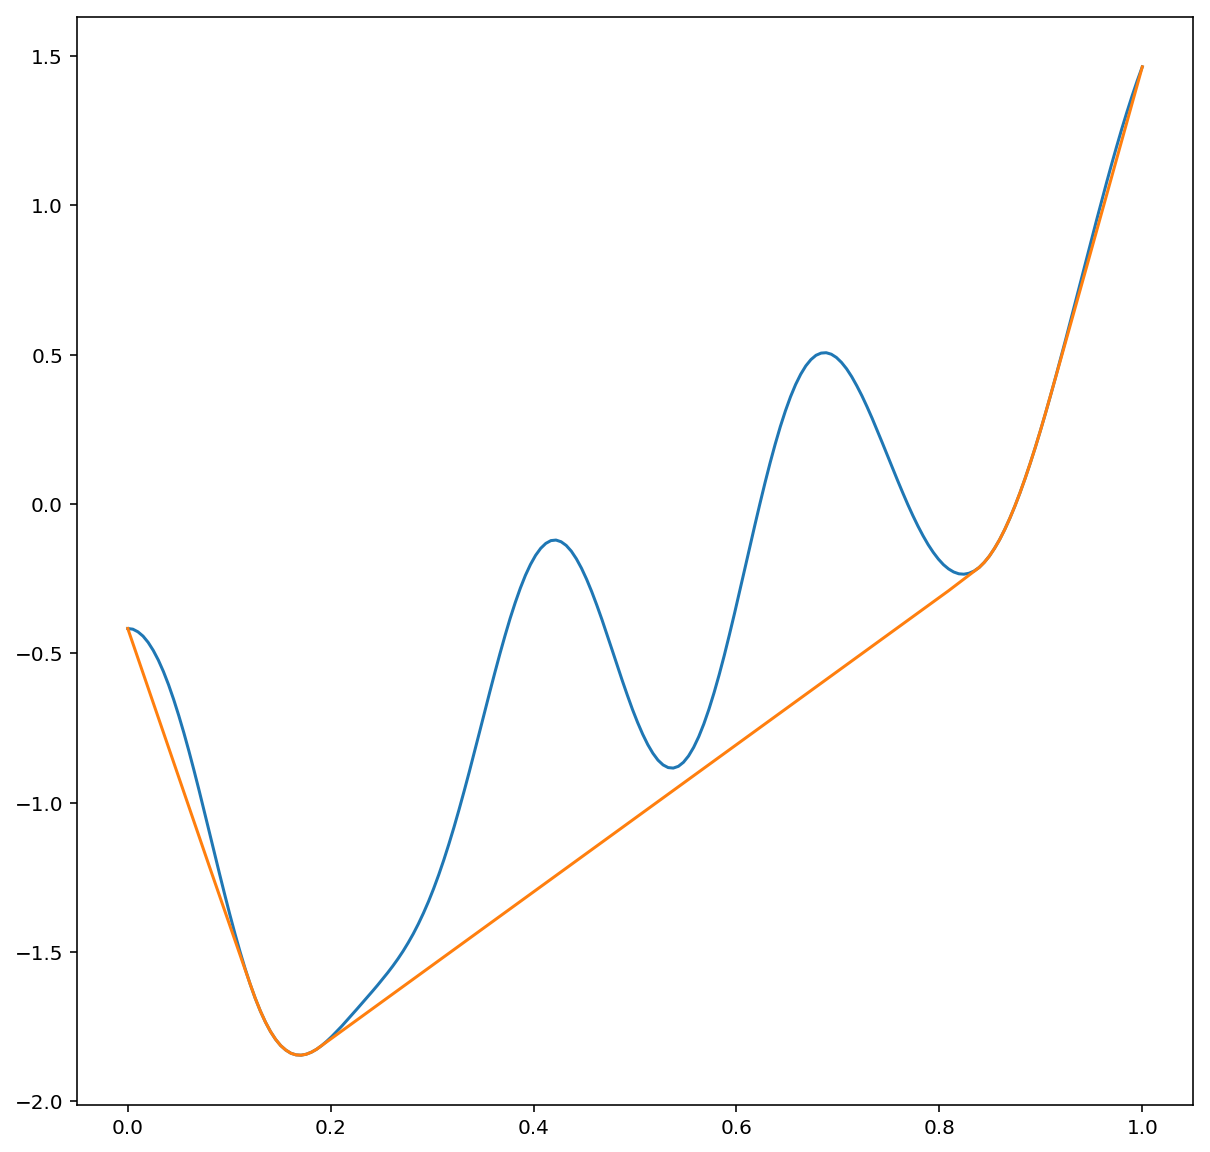

In [10]:
def convelope(knot_x, knot_y):
  knot_y = np.atleast_2d(knot_y) # samples x num_primal
  sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
  
  lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual

  lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
  return lft2
plt.figure(figsize=(10,10))
plt.plot(knot_x,  knot_y, knot_x, convelope(knot_x, knot_y).T)

In [11]:
def make_preds(train_x, train_y, test_x):
  # Compute the training kernels.
  train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
  cross_K = kernel(train_x, test_x, ls)
  kappa_K = kernel(test_x, test_x, ls)

  # Predictive parameters.
  train_cK = spla.cholesky(train_K)
  cross_solve = spla.cho_solve((train_cK,  False), cross_K)
  pred_mean = train_y.T @ cross_solve
  pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)

  return pred_mean, pred_cov

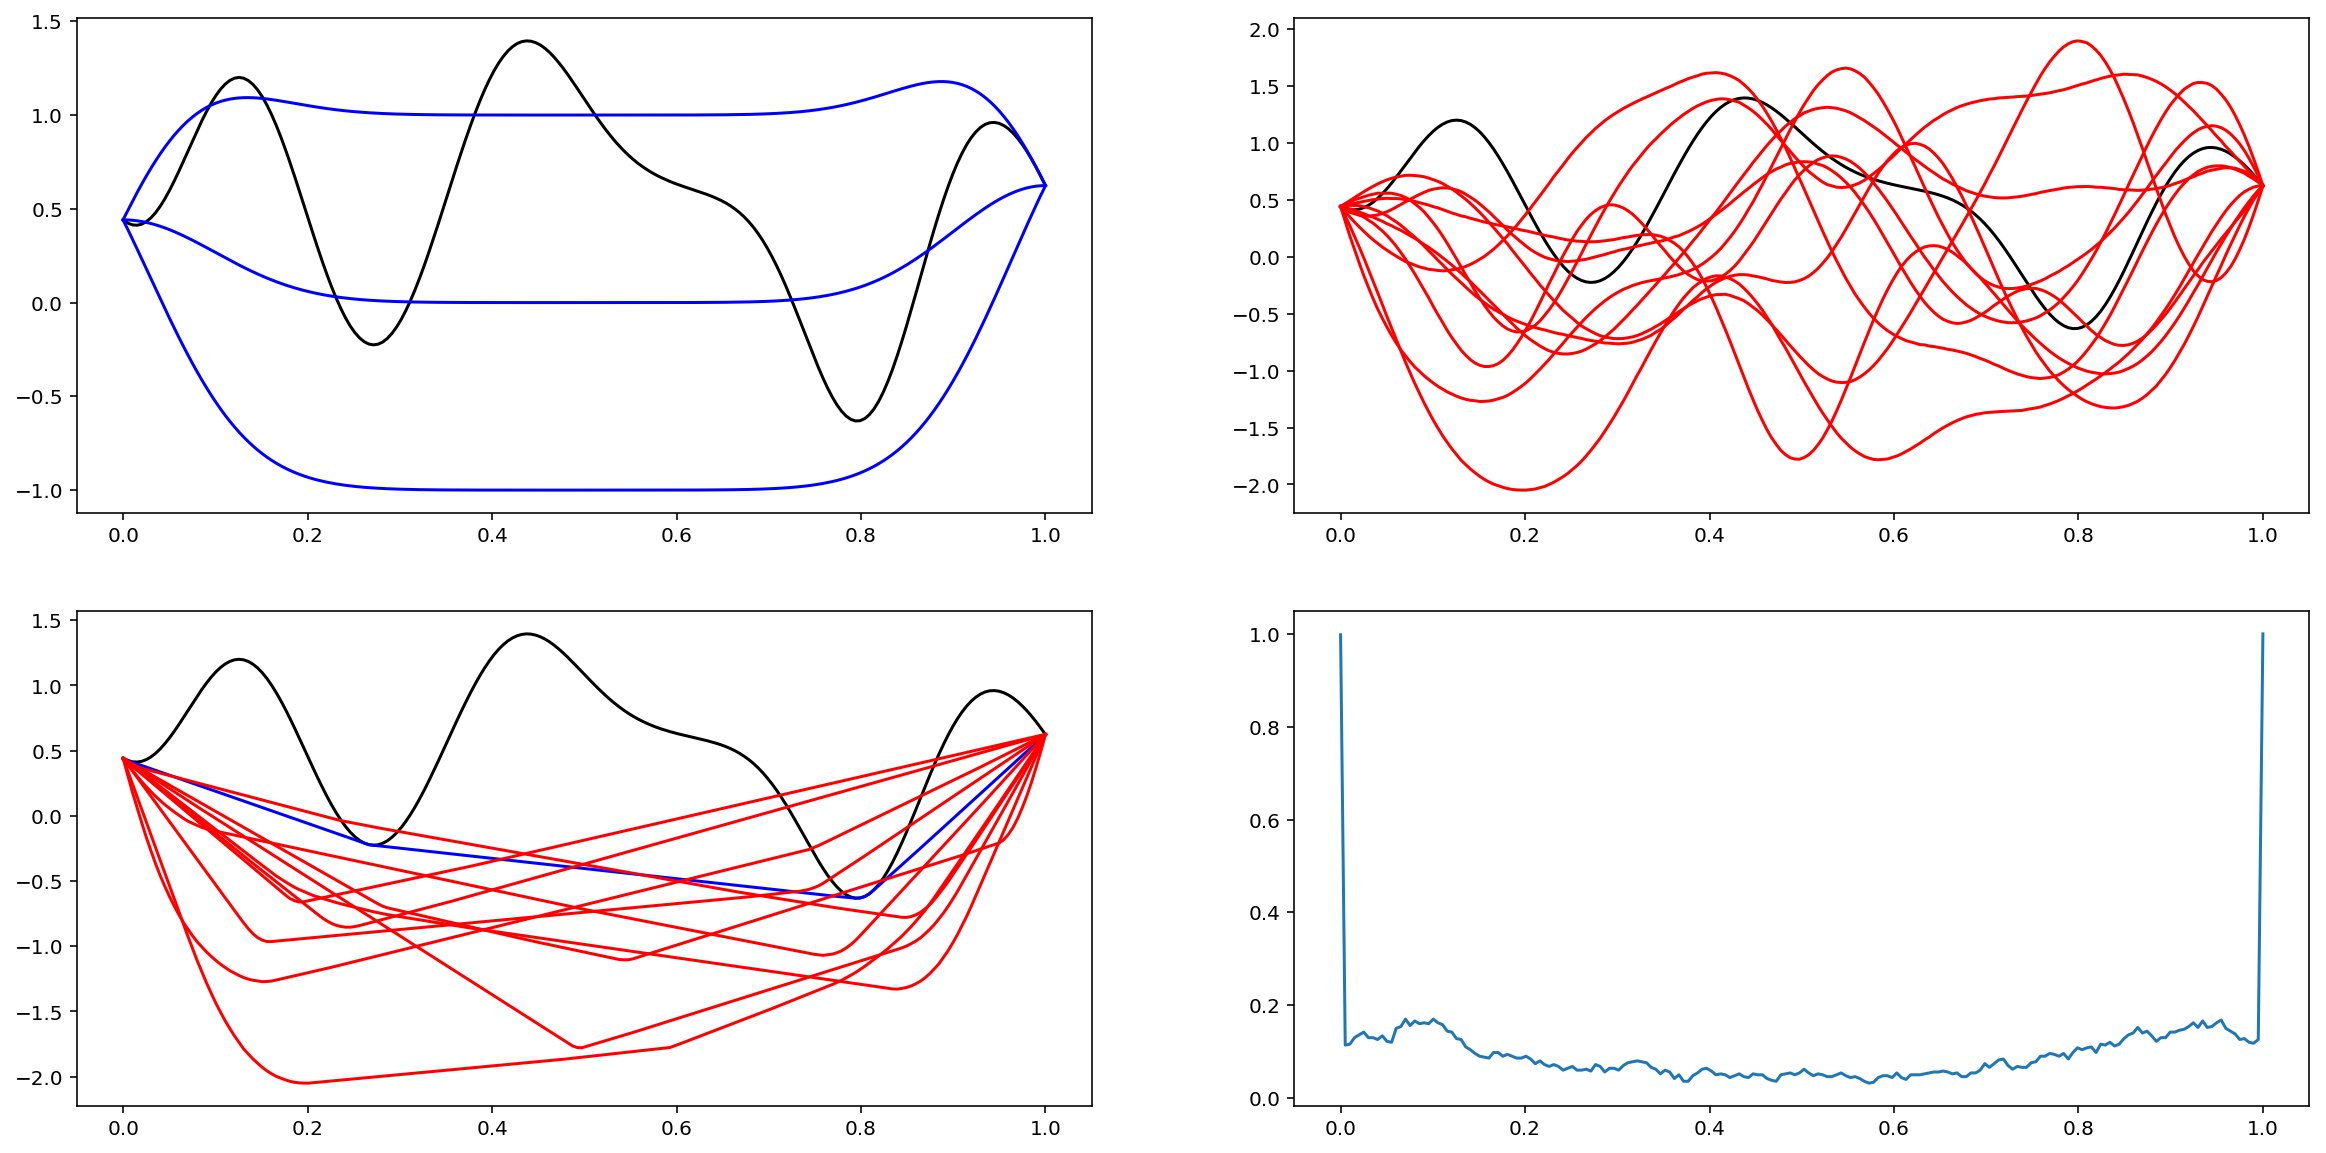

In [12]:
num_pred = 500

npr.seed(5)
true_y = knot_cK.T @ npr.randn(knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

envelopes = convelope(knot_x, pred_Y.T)
true_envelope = convelope(knot_x, true_y)

# TODO: what is this?
p_tight = np.clip(np.mean(np.abs(envelopes - pred_Y.T) < 1e-3, axis=0), 1e-6, 1-1e-6)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
plt.subplot(2,2,2)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
plt.subplot(2,2,3)
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
plt.subplot(2,2,4)
plt.plot(knot_x, p_tight)
plt.show()

100%|██████████| 200/200 [00:05<00:00, 34.57it/s]


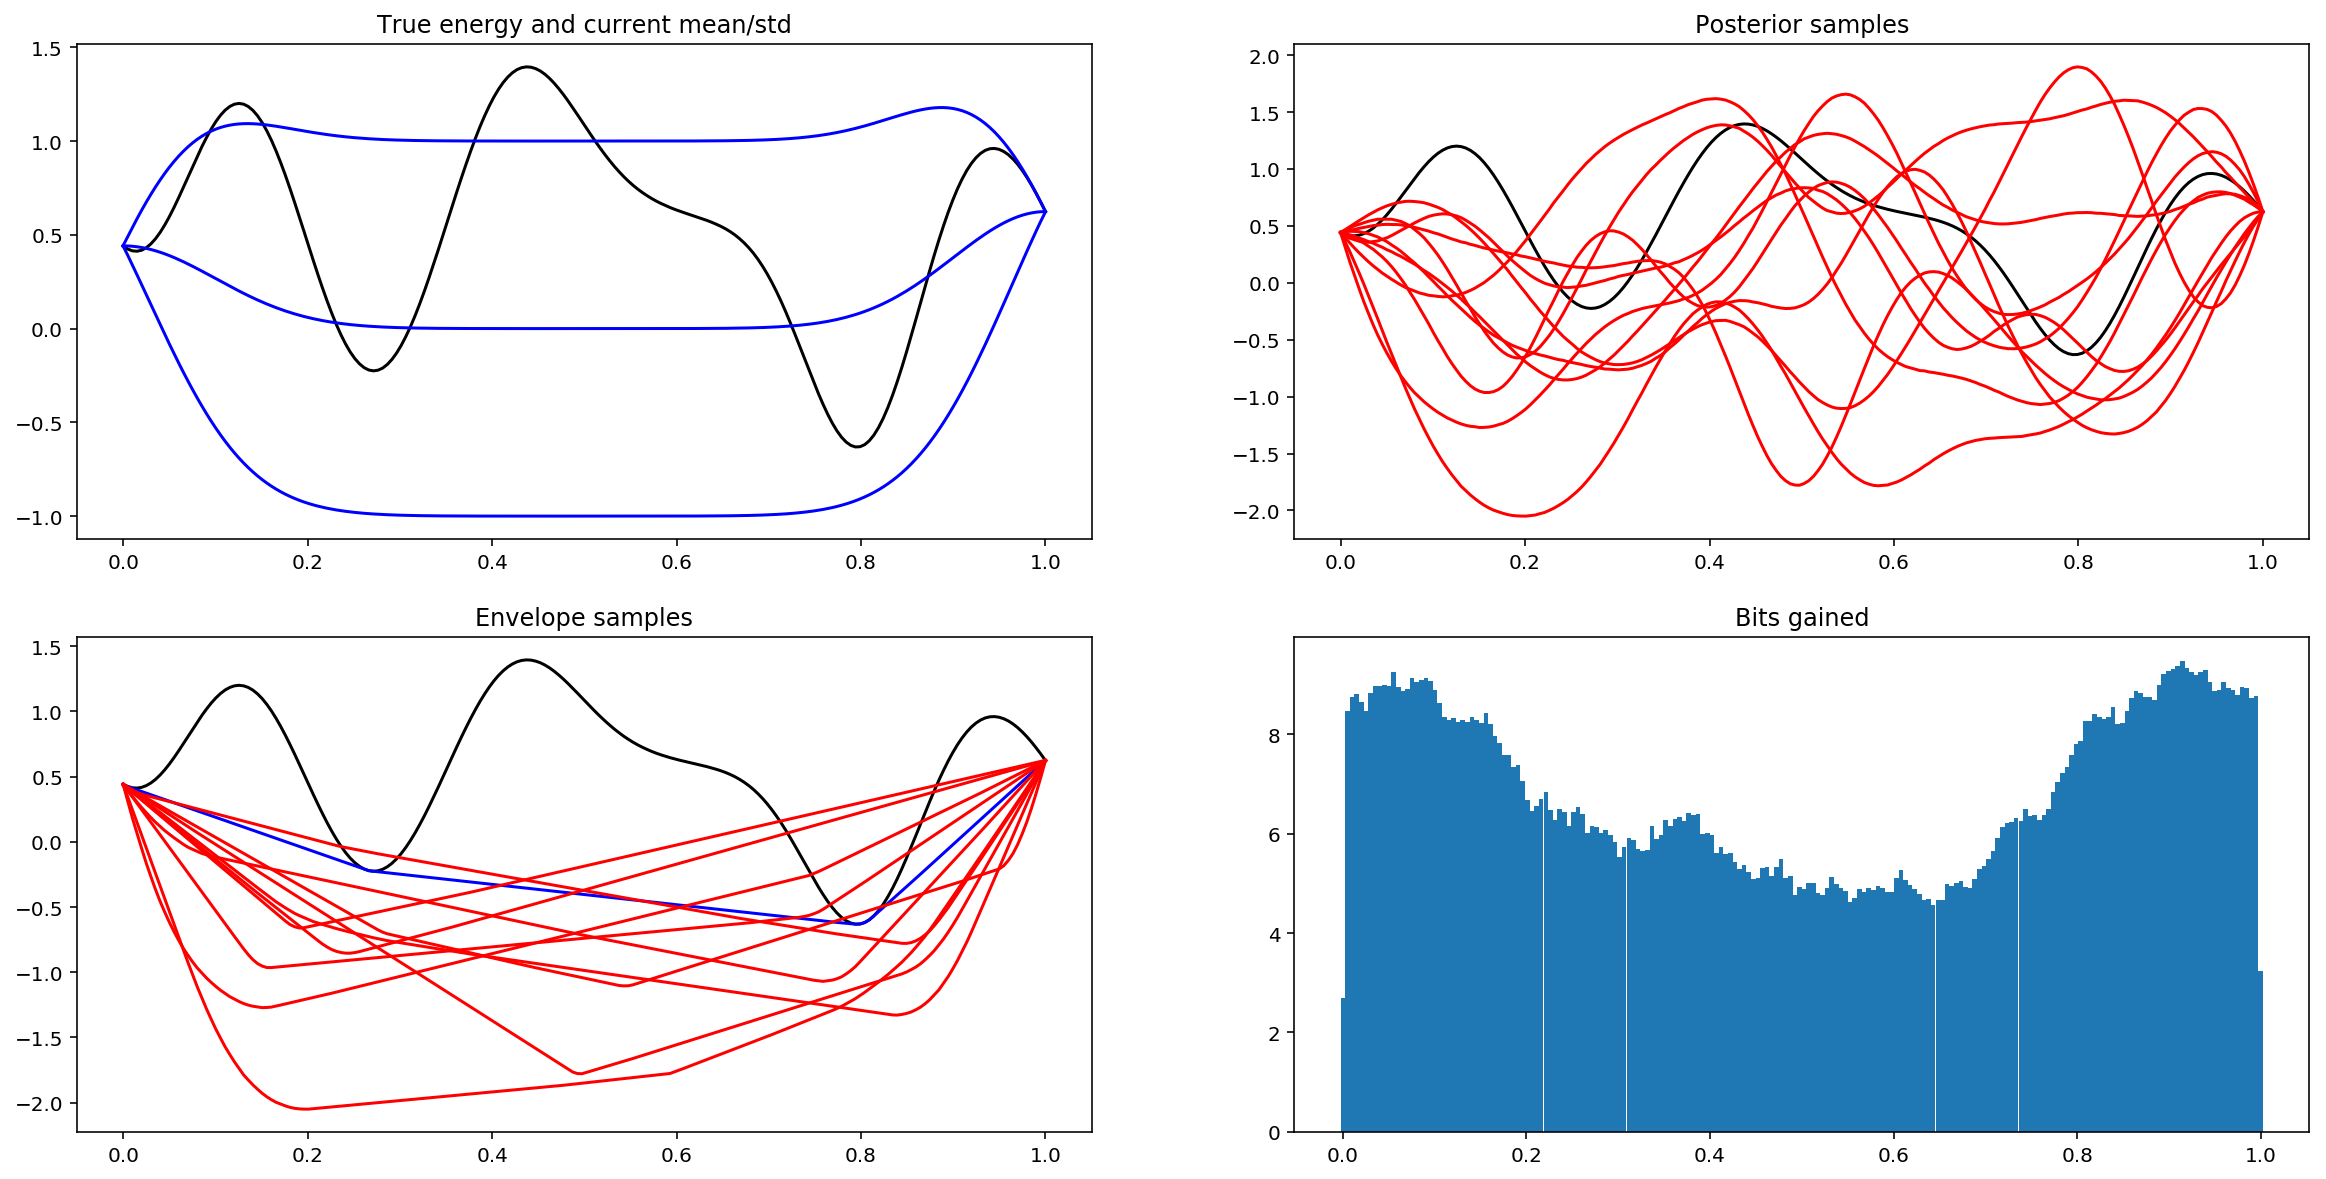

In [13]:
num_y_bins = 10

import scipy.stats as sps
u_borders = np.linspace(0, 1, num_y_bins+1)

envelopes = convelope(knot_x, pred_Y.T)
tights = np.abs(envelopes - pred_Y.T) < 1e-3
p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)

# Marginal bits
cur_entropy = -np.sum( p_tight*np.log2(p_tight) + (1-p_tight)*np.log2(1-p_tight))

# Do this with slow loops to start out. ### TODO: modify this
entropy_change = []
for nn in tqdm.tqdm(range(knot_N)):
  mean = pred_mean[nn]
  var  = pred_cov[nn,nn]
  borders = sps.norm.ppf(u_borders, loc=mean, scale=np.sqrt(var))[:,np.newaxis]
  Y = pred_Y[nn,:]
  Ybin = np.logical_and(borders[:-1] <= Y, Y < borders[1:]).T

  mean_entropy = 0
  for ii in range(num_y_bins):
    cond_p_tight = np.clip(np.mean(tights[Ybin[:,ii],:], axis=0), 1e-6, 1-1e-6)
    cond_entropy = -np.sum( cond_p_tight*np.log2(cond_p_tight) + (1-cond_p_tight)*np.log2(1-cond_p_tight))
    mean_entropy += cond_entropy/num_y_bins
  entropy_change.append(cur_entropy - mean_entropy)
entropy_change = np.array(entropy_change)

best_idx = np.argmax(entropy_change)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
plt.title('True energy and current mean/std')

plt.subplot(2,2,2)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
plt.title('Posterior samples')

plt.subplot(2,2,3)
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
plt.title('Envelope samples')

plt.subplot(2,2,4)
plt.bar(knot_x,  entropy_change, width=(1./knot_N))
plt.title('Bits gained')

plt.show()

train_x = np.append(train_x, knot_x[best_idx])
train_y = np.append(train_y, true_y[best_idx])

pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

## Slice sampling 

TODO: integrate thi

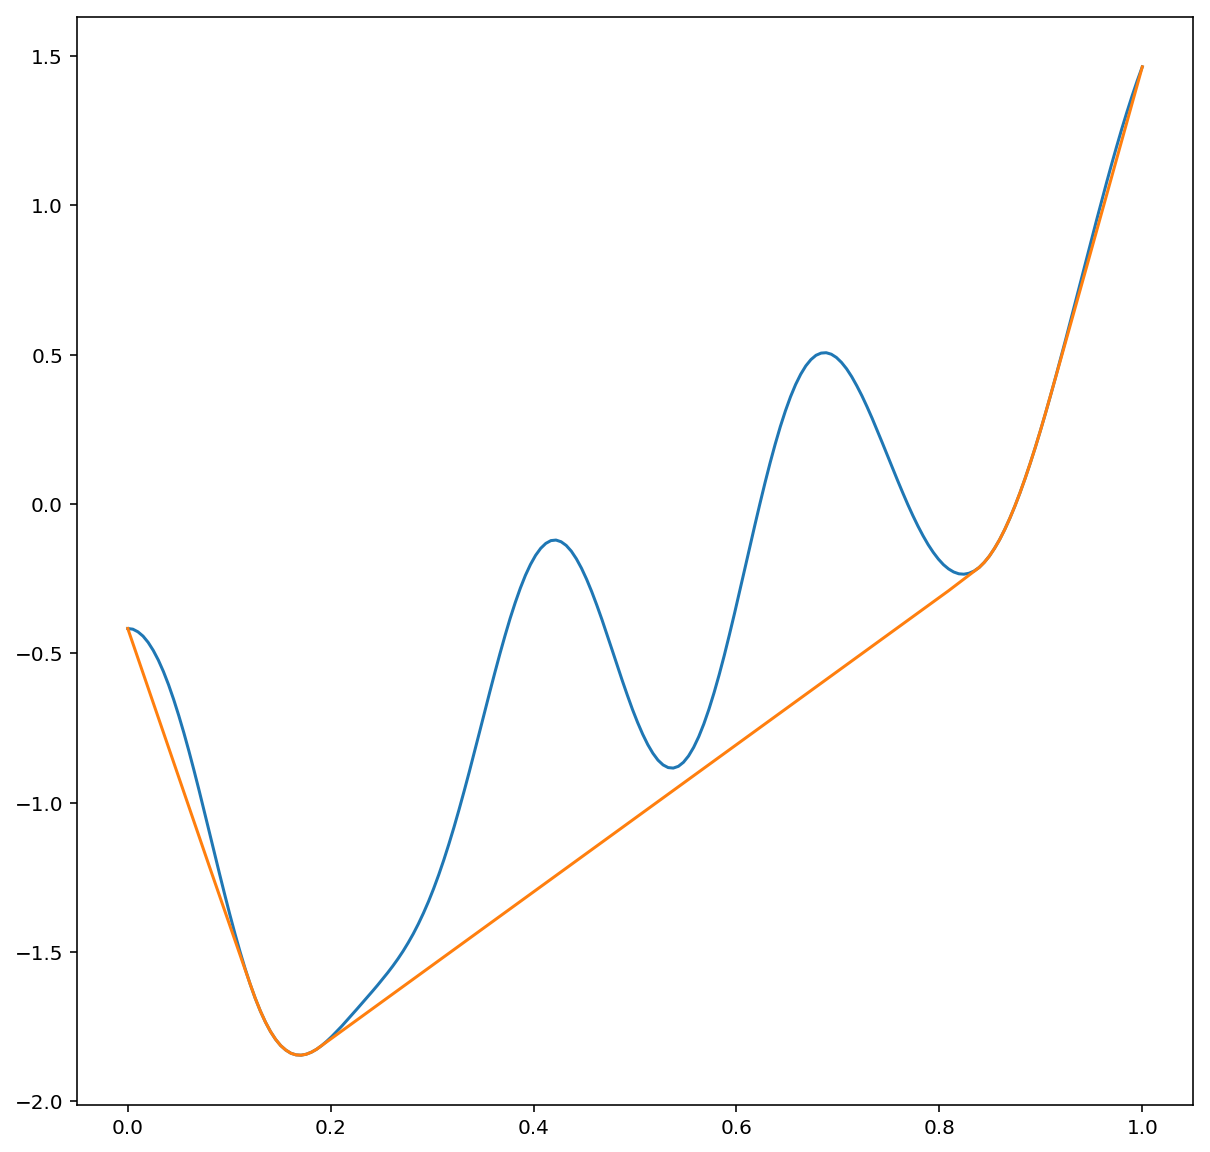

In [14]:
# Legendre-Fenchel Transform

# What range do we need to think about?
# Let's do 3 sigma.
deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

@jax.jit
def convelope(knot_x, knot_y):
  knot_y = np.atleast_2d(knot_y) # samples x num_primal
  sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
  
  lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual

  lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
  return lft2

hull = convelope(knot_x, knot_y).ravel()

plt.figure(figsize=(10,10))
plt.plot(knot_x,  knot_y, knot_x, hull)

In [15]:
tight = knot_y - hull < 1e-3
def same_tight(y, tight):
  new_hull = convelope(knot_x, y).ravel()
  new_tight = y - new_hull < 1e-3
  return np.all(tight == new_tight)

def var2entropy(v):
  return 0.5*np.log(2*np.pi*v) + 0.5

def make_preds(train_x, train_y, test_x):
  # Compute the training kernels.
  train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
  cross_K = kernel(train_x, test_x, ls)
  kappa_K = kernel(test_x, test_x, ls)

  # Predictive parameters.
  train_cK = spla.cholesky(train_K)
  cross_solve = spla.cho_solve((train_cK,  False), cross_K)
  pred_mean = train_y.T @ cross_solve
  pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)

  return pred_mean, pred_cov


  3%|▎         | 9/300 [00:00<00:12, 23.95it/s]

0 1 -0.003975763755083683


 36%|███▋      | 109/300 [00:01<00:02, 77.70it/s]

100 9 0.0044682035644056095


 70%|███████   | 211/300 [00:02<00:01, 82.89it/s]

200 6 0.017574112786275103


100%|██████████| 300/300 [00:03<00:00, 79.61it/s]


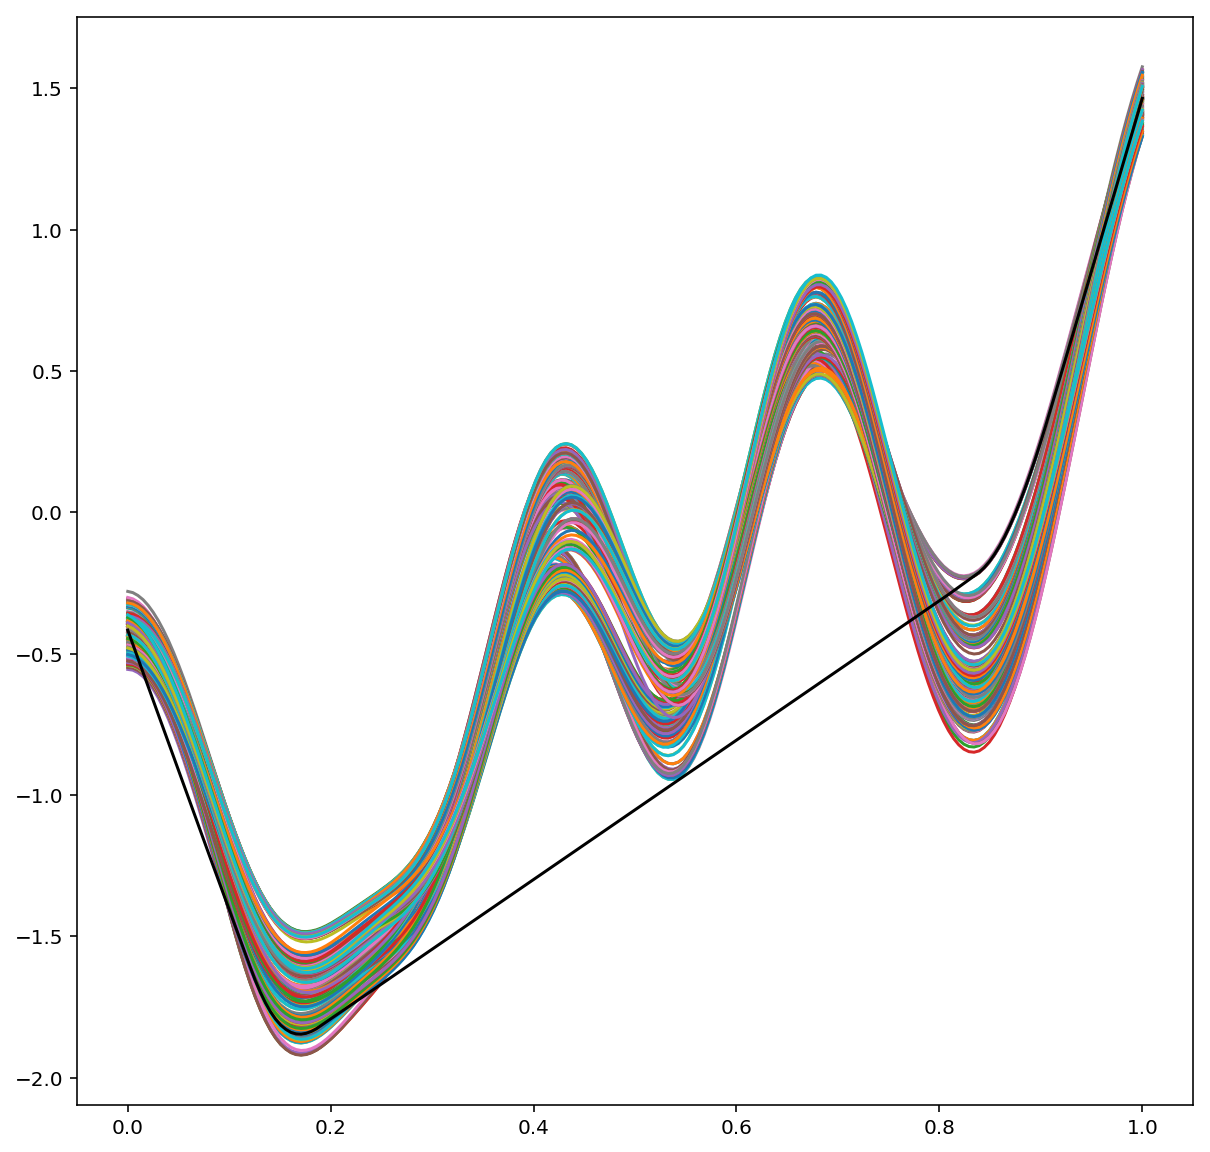

In [16]:
# Rewrite this in jax.
def elliptical_slice(x0, log_lh_func, cK, num_steps):
  D = x0.shape[0]
  samples = []
  x = x0
  for ii in tqdm.tqdm(range(num_steps)):
    nu = cK.T @ npr.randn(D)
    u = npr.rand()
    log_y = log_lh_func(x) + np.log(u)
    theta = npr.rand() * 2 * np.pi
    upper = theta
    lower = theta - 2 * np.pi
    shrinks = 0
    while True:
      theta = npr.rand()*(upper-lower) + lower
      new_x = x * np.cos(theta) + nu * np.sin(theta)
      if log_lh_func(new_x) > log_y:
        x = new_x
        break
      else:
        shrinks = shrinks + 1
        if theta > 0:
          upper = theta
        else:
          lower = theta
    if ii % 100 == 0:
      print(ii, shrinks, theta)
    samples.append(x)
  return np.array(samples)
samples = elliptical_slice(knot_y, lambda x: np.log(same_tight(x, tight)), knot_cK, 300)
plt.figure(figsize=(10,10))
plt.plot(knot_x, samples.T, knot_x, hull, 'k-')
plt.show()